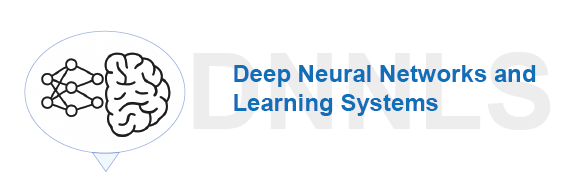

# Final assessment - Main Notebook
---

**Introduction:**

In this notebook you will find a baseline, functional architecture for your assessment task.

In [2]:
# @title Importing the necessary libraries
import torch
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
import torch.nn as nn
import torch.nn.functional as F

from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
import os

from datasets import load_dataset
from pathlib import Path

from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as FT

from transformers import BertTokenizer
import gc

import textwrap


Using device: cuda


Loading Configuration for Experiments

In [ ]:
import yaml
from pathlib import Path
drive.mount('/content/gdrive')

PROJECT_ROOT = Path('/content/gdrive/MyDrive/project_eniola-ak')

# CONFIG_NAME = 'configs/config_crossmodal.yaml'
CONFIG_NAME = 'configs/config_vae.yaml'
# CONFIG_NAME = 'configs/config_both.yaml'

config_path = PROJECT_ROOT / CONFIG_NAME

with open(config_path, 'r') as f:
  config = yaml.safe_load(f)

N_EPOCHS = config['training']['n_epochs']
BATCH_SIZE = config['training']['batch_size']
LEARNING_RATE = config['training']['learning_rate']
EXPERIMENT_NAME = config['training']['experiment_name']

LATENT_DIM = config['model']['latent_dim']
EMBEDDING_DIM = config['model']['embedding_dim']
GRU_HIDDEN_DIM = config['model']['gru_hidden_dim']
NUM_LAYERS = config['model']['num_layers']
DROPOUT = config['model']['dropout']
USE_CROSS_MODAL= config['model']['use_cross_modal_attention']
USE_VAE = config['model']['use_vae_decoder']

LOSS_IMG_W = config['loss']['image_weight']
LOSS_TEXT_W = config['loss']['text_weight']
LOSS_CTX_W = config['loss']['context_weight']
KL_WEIGHT = config['loss']['kl_weight']

RESULTS_DIR = PROJECT_ROOT / config['paths']['results_dir']
CHECKPOINT_DIR = PROJECT_ROOT / config['paths']['checkpoint_dir']
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Chapter 1: The data preparation**


---



First we need to activate our google drive so that we can save out data permanently.

## 1.1 Loading and saving data

In [4]:
def save_checkpoint_to_drive(model, optimizer, epoch, loss, filename="autoencoder_checkpoint.pth"):
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'
    os.makedirs(drive_folder, exist_ok=True)
    full_path = os.path.join(drive_folder, filename)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, full_path)
    print(f"Checkpoint saved to Google Drive: {full_path} at epoch {epoch}")

def load_checkpoint_from_drive(model, optimizer=None, filename="autoencoder_checkpoint.pth"):
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'
    full_path = os.path.join(drive_folder, filename)
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Checkpoint file not found: {full_path}")
    checkpoint = torch.load(full_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint.get('epoch', 0)
    loss = checkpoint.get('loss', None)
    print(f"Checkpoint loaded from: {full_path} (epoch {epoch})")
    return model, optimizer, epoch, loss

We need to define a couple of functions to make our life easier. Feel free to tweak those functions:

In [5]:
def parse_gdi_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    images = []

    for gdi in soup.find_all('gdi'):
        image_id = None
        if gdi.attrs:
            for attr_name, attr_value in gdi.attrs.items():
                if 'image' in attr_name.lower():
                    image_id = attr_name.replace('image', '')
                    break
        if not image_id:
            tag_str = str(gdi)
            match = re.search(r'<gdi\s+image(\d+)', tag_str)
            if match:
                image_id = match.group(1)
        if not image_id:
            image_id = str(len(images) + 1)
        content = gdi.get_text().strip()
        objects = [obj.get_text().strip() for obj in gdi.find_all('gdo')]
        actions = [act.get_text().strip() for act in gdi.find_all('gda')]
        locations = [loc.get_text().strip() for loc in gdi.find_all('gdl')]

        images.append({
            'image_id': image_id,
            'description': content,
            'objects': objects,
            'actions': actions,
            'locations': locations,
            'raw_text': str(gdi)
        })

    return images

def show_image(ax, image, de_normalize = False, img_mean = None, img_std = None):
  if de_normalize:
    new_mean = -img_mean/img_std
    new_std = 1/img_std

    image = transforms.Normalize(
        mean=new_mean,
        std=new_std
    )(image)
  ax.imshow(image.permute(1, 2, 0))

Now we load dataset from HuggingFace:

In [6]:
# @title Loading the dataset
train_dataset = load_dataset("daniel3303/StoryReasoning", split="train")
test_dataset = load_dataset("daniel3303/StoryReasoning", split="test")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In a previous lab, we analyzed the statistics of the images and figure out that a size of 240x500 could be good enough to standarize, but we will use 60x125. Also, we will restrict ourselves to taking only 5 frames from all the sequences.


## 1.2 Three datasets


---



We will create three different dataset objects and the corresponding loaders for performing multiple tasks

In [7]:
# @title Main dataset
class SequencePredictionDataset(Dataset):
    def __init__(self, original_dataset, tokenizer):
        super(SequencePredictionDataset, self).__init__()
        self.dataset = original_dataset
        self.tokenizer = tokenizer
        self.transform = transforms.Compose([
          transforms.Resize((60, 125)),
          transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]
      self.image_attributes = parse_gdi_text(self.dataset[idx]["story"])

      frame_tensors = []
      description_list = []

      for frame_idx in range(4):
        image = FT.equalize(frames[frame_idx])
        input_frame = self.transform(image)
        frame_tensors.append(input_frame)
        description = self.image_attributes[frame_idx]["description"]
        input_ids =  self.tokenizer(description,
                             return_tensors="pt",
                             padding="max_length",
                             truncation=True,
                             max_length=120).input_ids
        description_list.append(input_ids.squeeze(0))

      image_target = FT.equalize(frames[4])
      image_target = self.transform(image_target)
      text_target = self.image_attributes[4]["description"]

      target_ids = self.tokenizer(text_target,
                             return_tensors="pt",
                             padding="max_length",
                             truncation=True,
                             max_length=120).input_ids

      sequence_tensor = torch.stack(frame_tensors)
      description_tensor = torch.stack(description_list)

      return (sequence_tensor,
              description_tensor,
              image_target,
              target_ids)

We will use text autoencoding (reconstructing the same text) to develop representations of the text (I provide some existing weights for this, but you can train your own)

In [8]:
# @title Text task dataset (text autoencoding)
class TextTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      self.image_attributes = parse_gdi_text(self.dataset[idx]["story"])
      frame_idx = np.random.randint(0, 5)
      description = self.image_attributes[frame_idx]["description"]

      return description


And also a dataset for a potential image autoencoder task if you want to develop some visual features before training the whose archicture.

In [9]:
# @title Dataset for image autoencoder task
class AutoEncoderTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
          transforms.Resize((240, 500)),
          transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]
      frame_idx = torch.randint(0, num_frames-1, (1,)).item()
      input_frame = self.transform(frames[frame_idx])

      return input_frame,

## 1.3 Creating and testing our dataset objects and loaders


---



In [10]:
# @title For the Sequence prediction task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
sp_train_dataset = SequencePredictionDataset(train_dataset, tokenizer)
sp_test_dataset = SequencePredictionDataset(test_dataset, tokenizer)

train_size = int(0.8 * len(sp_train_dataset))
val_size = len(sp_train_dataset) - train_size
train_subset, val_subset = random_split(sp_train_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=BATCH_SIZE//2, shuffle=True)
test_dataloader = DataLoader(sp_test_dataset, batch_size=BATCH_SIZE//2, shuffle=False)

In [11]:
# @title For the text task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
text_dataset = TextTaskDataset(train_dataset)
text_dataloader = DataLoader(text_dataset, batch_size=4, shuffle=True)

In [12]:
# @title For the image autoencoder task
autoencoder_dataset = AutoEncoderTaskDataset(train_dataset)
autoencoder_dataloader = DataLoader(autoencoder_dataset, batch_size=4, shuffle=True)

Description:  torch.Size([4, 120])
torch.Size([8, 4, 3, 60, 125])
torch.Size([8, 4, 120])


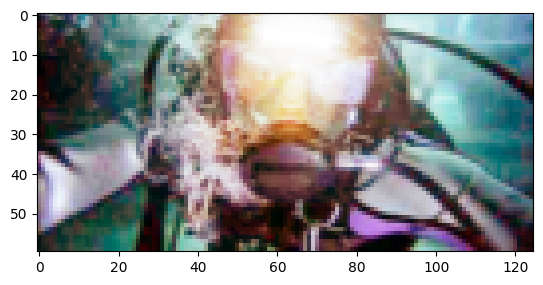

In [13]:
# @title Testing some of the outputs of the SP dataset
frames, descriptions, image_target, text_target = sp_train_dataset[np.random.randint(0,400)]

print("Description: ", descriptions.shape)
figure, ax = plt.subplots(1,1)
show_image(ax, image_target)
frames, descriptions, image_target, text_target = next(iter(train_dataloader))
print(frames.shape)
print(descriptions.shape)

I will leave the test of the other datasets to you.

# **Chapter 2: Models**


---



We provide a simple text encoder based on a recurrent neural network (LSTM). Feel free to provide your own text encoder.

## 2.1 The NLP models

In [14]:
# @title The text autoencoder (Seq2Seq)

class EncoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.out = nn.Linear(hidden_dim, vocab_size) # Should be hidden_dim

    def forward(self, input_seq, hidden, cell):
        embedded = self.embedding(input_seq)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, target_seq):
        _enc_out, hidden, cell = self.encoder(input_seq)
        decoder_input = target_seq[:, :-1]
        predictions, _hidden, _cell = self.decoder(decoder_input, hidden, cell)
        return predictions

In [15]:
def generate(model, hidden, cell, max_len, sos_token_id, eos_token_id, device=None):
    if device is None:
        device = torch.device("cpu")
    model.eval()
    dec_input = torch.tensor([[sos_token_id]], dtype=torch.long, device=device)
    generated_tokens = []

    for _ in range(max_len):
        with torch.no_grad():
            prediction, hidden, cell = model(dec_input, hidden, cell)
        logits = prediction.squeeze(1)
        temperature = 0.9
        probabilities = torch.softmax(logits / temperature, dim=-1)
        next_token = torch.multinomial(probabilities, num_samples=1)
        token_id = next_token.squeeze().item()
        if token_id == eos_token_id:
            break
        if token_id != 0 and token_id != sos_token_id:
            generated_tokens.append(token_id)
        dec_input = next_token

    return generated_tokens

## 2.2 The Vision models

In [16]:
# @title The visual autoencoder
class Backbone(nn.Module):
    def __init__(self, latent_dim=128):
        super(Backbone, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.flatten_dim = 256 * 8 * 16
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, latent_dim),
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x_flat = x4.view(-1, self.flatten_dim)
        z = self.fc(x_flat)
        return z

class VisualEncoder(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, 3, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 60, 125)
            out = self.conv_layers(dummy)
            self.flatten_size = out.numel()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, latent_dim),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        z = self.fc(x)
        return z

class VisualDecoder(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512 * 8 * 16),
            nn.ReLU(inplace=True),
        )

        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 32, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 8, 16)
        x = self.deconv_layers(x)
        x = F.interpolate(x, size=(60, 125), mode='bilinear', align_corners=False)
        return x

class VariationalDecoder(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()
        self.fc_mean = nn.Linear(latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(latent_dim, latent_dim)
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512 * 8 * 16),
            nn.ReLU(inplace=True),
        )

        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 32, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Sigmoid(),
        )

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, z):
        mean = self.fc_mean(z)
        logvar = self.fc_logvar(z)
        logvar = torch.clamp(logvar, -10, 10)
        z_sample = self.reparameterize(mean, logvar)
        x = self.fc(z_sample)
        x = x.view(-1, 512, 8, 16)
        x = self.deconv_layers(x)
        x = F.interpolate(x, size=(60, 125), mode='bilinear', align_corners=False)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / z.size(0)
        return x, x, kl_loss

class VisualAutoencoder(nn.Module):
    def __init__(self, latent_dim=128, use_vae=True):
        super(VisualAutoencoder, self).__init__()
        self.encoder = VisualEncoder(latent_dim)
        if use_vae:
            self.decoder = VariationalDecoder(latent_dim)
            self.use_vae = True
        else:
            self.decoder = VisualDecoder(latent_dim)
            self.use_vae = False

    def forward(self, x):
        z = self.encoder(x)
        if self.use_vae:
            x_content, x_context, kl_loss = self.decoder(z)
            return x_content, x_context, kl_loss
        else:
            x_recon = self.decoder(z)
            return x_recon, x_recon, torch.tensor(0.0).to(x.device)

## 2.3 The main architecture


In [17]:
# @title A simple attention architecture

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, rnn_outputs):
        energy = self.attn(rnn_outputs).squeeze(2)
        attn_weights = self.softmax(energy)
        context = torch.bmm(attn_weights.unsqueeze(1), rnn_outputs)
        return context.squeeze(1)

Cross Modal Attention Mechanism

In [18]:
class CrossModalAttention(nn.Module):
    def __init__(self, visual_dim, text_dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = visual_dim // num_heads

        self.query_proj = nn.Linear(text_dim, visual_dim)
        self.key_proj = nn.Linear(visual_dim, visual_dim)
        self.value_proj = nn.Linear(visual_dim, visual_dim)
        self.out_proj = nn.Linear(visual_dim, visual_dim)

    def forward(self, text_features, visual_features):
        B = visual_features.size(0)
        Q = self.query_proj(text_features).view(B, 1, self.num_heads, self.head_dim)
        Q = Q.permute(0, 2, 1, 3)
        K = self.key_proj(visual_features).view(B, -1, self.num_heads, self.head_dim)
        K = K.permute(0, 2, 3, 1)
        V = self.value_proj(visual_features).view(B, -1, self.num_heads, self.head_dim)
        V = V.permute(0, 2, 1, 3)
        attn = torch.matmul(Q, K) / math.sqrt(self.head_dim)
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, V)
        out = out.permute(0, 2, 1, 3).contiguous()
        out = out.view(B, -1)

        return self.out_proj(out)

In [19]:
# @title The main sequence predictor model

class SequencePredictor(nn.Module):
    def __init__(self, visual_autoencoder, text_autoencoder, latent_dim,
             gru_hidden_dim, use_cross_modal_attention=False, use_vae_decoder=False):
        super(SequencePredictor, self).__init__()

        self.use_cross_modal = use_cross_modal_attention
        self.use_vae = use_vae_decoder
        self.image_encoder = visual_autoencoder.encoder
        self.text_encoder = text_autoencoder.encoder
        self.text_num_layers = text_autoencoder.encoder.num_layers
        self.text_hidden_dim = text_autoencoder.encoder.hidden_dim

        if self.text_num_layers == 1:
            text_feature_dim = self.text_hidden_dim
        else:
            text_feature_dim = self.text_hidden_dim * 2

        fusion_dim = latent_dim + text_feature_dim
        self.temporal_rnn = nn.GRU(fusion_dim, gru_hidden_dim, batch_first=True)

        self.attention = Attention(gru_hidden_dim)

        if use_cross_modal_attention:
            self.cross_modal_attention = CrossModalAttention(
                visual_dim=gru_hidden_dim,
                text_dim=text_feature_dim,
                num_heads=4
            )

        self.projection = nn.Sequential(
            nn.Linear(gru_hidden_dim * 2, latent_dim),
            nn.ReLU()
        )

        if use_vae_decoder:
            self.image_decoder = VariationalDecoder(latent_dim)
        else:
            self.image_decoder = visual_autoencoder.decoder

        self.text_decoder = text_autoencoder.decoder
        self.fused_to_h0 = nn.Linear(latent_dim, self.text_num_layers * self.text_hidden_dim)
        self.fused_to_c0 = nn.Linear(latent_dim, self.text_num_layers * self.text_hidden_dim)

    def forward(self, image_seq, text_seq, target_seq):
        batch_size, seq_len, C, H, W = image_seq.shape
        img_flat = image_seq.view(batch_size * seq_len, C, H, W)
        txt_flat = text_seq.view(batch_size * seq_len, -1)

        z_v_flat = self.image_encoder(img_flat)
        _, hidden, cell = self.text_encoder(txt_flat)
        if self.text_num_layers == 1:
          text_features_flat = hidden.squeeze(0)

        else:
          hidden_forward = hidden[-2, :, :]
          hidden_backward = hidden[-1, :, :]
          text_features_flat = torch.cat([hidden_forward, hidden_backward], dim=1)
        z_fusion_flat = torch.cat((z_v_flat, text_features_flat), dim=1)
        z_fusion_seq = z_fusion_flat.view(batch_size, seq_len, -1)
        zseq, h = self.temporal_rnn(z_fusion_seq)
        h = h.squeeze(0)
        if self.use_cross_modal:
            text_features_seq = text_features_flat.view(batch_size, seq_len, -1)
            text_feat_last = text_features_seq[:, -1, :]
            attended = self.cross_modal_attention(text_feat_last, zseq)
            h = h + attended
        context = self.attention(zseq)
        z = self.projection(torch.cat((h, context), dim=1))
        if self.use_vae:
            pred_image_content, pred_image_context, kl_loss = self.image_decoder(z)
        else:
            pred_image_content = self.image_decoder(z)
            pred_image_context = pred_image_content
            kl_loss = torch.tensor(0.0).to(z.device)
        h0 = self.fused_to_h0(z).view(self.text_num_layers, batch_size, self.text_hidden_dim)
        c0 = self.fused_to_c0(z).view(self.text_num_layers, batch_size, self.text_hidden_dim)
        decoder_input = target_seq.squeeze(1)[:, :-1]
        predicted_text_logits_k, _, _ = self.text_decoder(decoder_input, h0, c0)

        return pred_image_content, pred_image_context, predicted_text_logits_k, h0, c0, kl_loss

# **Chapter 3: Training routines**


---




In [20]:
# @title Training utility functions: To initialize and to visualize the progress
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(m.bias, 0)

def validation(model, data_loader, epoch, tokenizer, device, save_dir=None):
    model.eval()

    with torch.no_grad():
        frames, descriptions, image_target, text_target = next(iter(data_loader))

        descriptions = descriptions.to(device)
        frames = frames.to(device)
        image_target = image_target.to(device)
        text_target = text_target.to(device)

        pred_image_k, context_image, _, hidden, cell, _ = model(
            frames, descriptions, text_target
        )
        sos_token_id = tokenizer.convert_tokens_to_ids(tokenizer.cls_token)
        eos_token_id = tokenizer.convert_tokens_to_ids(tokenizer.sep_token)

        hidden_single =hidden[:, 0:1, :].contiguous()
        cell_single = cell[:, 0:1, :].contiguous()

        generated_tokens= generate (
            model.text_decoder,
            hidden_single,
            cell_single,
            sos_token_id= sos_token_id,
            eos_token_id = eos_token_id,
            device=device,
            max_len=180
        )

        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

        figure, ax = plt.subplots(2, 6, figsize=(20, 5))
        for i in range(4):
            im = frames[0, i, :, :, :].cpu()
            ax[0, i].imshow(im.permute(1, 2, 0))
            ax[0, i].set_aspect('auto')
            ax[0, i].axis('off')

            text_desc = tokenizer.decode(descriptions[0, i, :], skip_special_tokens=True)
            wrapped = textwrap.fill(text_desc, width=40)
            ax[1, i].text(0.5, 0.99, wrapped, ha='center', va='top', fontsize=10)
            ax[1, i].axis('off')
        ax[0, 4].imshow(image_target[0].cpu().permute(1, 2, 0))
        ax[0, 4].set_title('Target Image', fontsize=12, fontweight='bold')
        ax[0, 4].axis('off')

        text_target_sq = text_target.squeeze(1)
        target_text = tokenizer.decode(text_target_sq[0], skip_special_tokens=True)
        ax[1, 4].text(0.5, 0.99, textwrap.fill(target_text, width=40),
                     ha='center', va='top', fontsize=10)
        ax[1, 4].axis('off')
        ax[0, 5].imshow(context_image[0, :, :, :].cpu().permute(1, 2, 0))
        ax[0, 5].set_title('Predicted Image', fontsize=12, fontweight='bold')
        ax[0, 5].axis('off')

        ax[1, 5].text(0.5, 0.99, textwrap.fill(generated_text,width = 40), ha='center', va='top', fontsize=10)
        ax[1, 5].axis('off')

        plt.tight_layout()
        if save_dir:
            save_dir_path = Path(save_dir)
            save_dir_path.mkdir(parents=True, exist_ok=True)
            save_path = save_dir_path / f'epoch_{epoch:03d}.png'
            plt.savefig(save_path, dpi=100, bbox_inches='tight')
            print(f" Visualization saved: {save_path}")
            plt.close()
        else:
            plt.show()

    model.train()

## 3.1 Initialization and setup

In [21]:
# @title Variables and initial setup
torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_EPOCHS = config['training']['n_epochs']
emb_dim = EMBEDDING_DIM
latent_dim = LATENT_DIM
num_layers = NUM_LAYERS
dropout = DROPOUT
text_hidden_dim = config['model'].get('text_hidden_dim', LATENT_DIM)
BATCH_SIZE = BATCH_SIZE
LEARNING_RATE = LEARNING_RATE

In [22]:
# @title Initializing the NLP models
encoder = EncoderLSTM(tokenizer.vocab_size, emb_dim, text_hidden_dim, num_layers, dropout).to(device)
decoder = DecoderLSTM(tokenizer.vocab_size, emb_dim, text_hidden_dim, num_layers, dropout).to(device)
text_autoencoder = Seq2SeqLSTM(encoder, decoder).to(device)
#text_autoencoder, _, _, _ = load_checkpoint_from_drive(text_autoencoder, None, filename='text_autoencoder.pth')

total_params = sum(p.numel() for p in text_autoencoder.parameters())
print(f"Total parameters (Not trainable): {total_params}")
for param in text_autoencoder.parameters():
        param.requires_grad = True

print("I am training from scratch. removed pretrained weights due to small dimensions")


Total parameters (Not trainable): 57879866
I am training from scratch. removed pretrained weights due to small dimensions


In [23]:
# @title Initializing visual models
visual_autoencoder = VisualAutoencoder(latent_dim=LATENT_DIM, use_vae=USE_VAE)
visual_autoencoder.apply(init_weights)

total_params = sum(p.numel() for p in visual_autoencoder.parameters() if p.requires_grad)
print(f"Total trainable parameters in visual autoencoder: {total_params}")

Total trainable parameters in visual autoencoder: 139267523


In [24]:
# @title Initialize the main architecture
sequence_predictor = SequencePredictor(visual_autoencoder, text_autoencoder, latent_dim=LATENT_DIM, gru_hidden_dim=GRU_HIDDEN_DIM, use_cross_modal_attention= USE_CROSS_MODAL,use_vae_decoder=USE_VAE)
sequence_predictor.to(device)
total_params = sum(p.numel() for p in sequence_predictor.parameters() if p.requires_grad)
print(f"Total trainable parameters in the whole model: {total_params}")
total_params = sum(p.numel() for p in sequence_predictor.parameters())
print(f"Total parameters: {total_params}")

Total trainable parameters in the whole model: 198330110
Total parameters: 198330110


## 3.2 Training loops

In [25]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.l1 = nn.L1Loss()

    def forward(self, pred, target):
        return 0.5 * self.l1(pred, target) + 0.5 * self.mse(pred, target)

criterion_images = PerceptualLoss()
criterion_ctx = nn.MSELoss()
criterion_text = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token))
optimizer = torch.optim.AdamW(
    sequence_predictor.parameters(),
    lr=0.001,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

from torch.optim.lr_scheduler import OneCycleLR

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.003,
    epochs=50,
    steps_per_epoch=len(train_dataloader),
    pct_start=0.1,
    anneal_strategy='cos',
    div_factor=3.0,
    final_div_factor=100
)

In [26]:
# @title Load checkpoint to resume training
RESUME_FROM_CHECKPOINT = False
CHECKPOINT_TO_LOAD = "cross_modal_plus_vae_epoch_049.pth"

if RESUME_FROM_CHECKPOINT:
    checkpoint_path = CHECKPOINT_DIR / CHECKPOINT_TO_LOAD

    if checkpoint_path.exists():
        checkpoint = torch.load(checkpoint_path)

        sequence_predictor.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1

        print(f"Resumed from epoch {checkpoint['epoch']}")
        print(f"Previous loss: {checkpoint['loss']:.4f}")
        print(f"Starting from epoch {start_epoch}")
    else:
        print(f" Checkpoint not found: {checkpoint_path}")
        start_epoch = 0
else:
    start_epoch = 0

Epoch [1/50], Loss: 61.0010
Epoch [2/50], Loss: 48.2543
Epoch [3/50], Loss: 38.5515
Epoch [4/50], Loss: 34.0112
Epoch [5/50], Loss: 31.1678
Epoch [6/50], Loss: 29.0739
Epoch [7/50], Loss: 27.4512
Epoch [8/50], Loss: 26.0744
Epoch [9/50], Loss: 24.9810

Validation on training dataset
----------------
 Visualization saved: /content/gdrive/MyDrive/project_eniola-ak/results/vae_decoder/visualizations/epoch_009.png

Validation on validation dataset
----------------
 Visualization saved: /content/gdrive/MyDrive/project_eniola-ak/results/vae_decoder/visualizations/epoch_009.png
Epoch [10/50], Loss: 24.0639
Epoch [11/50], Loss: 23.2302
Epoch [12/50], Loss: 22.4194
Epoch [13/50], Loss: 21.7203
Epoch [14/50], Loss: 21.0941
Epoch [15/50], Loss: 20.4648
Epoch [16/50], Loss: 19.8932
Epoch [17/50], Loss: 19.3304
Epoch [18/50], Loss: 18.8212
Epoch [19/50], Loss: 18.3254

Validation on training dataset
----------------
 Visualization saved: /content/gdrive/MyDrive/project_eniola-ak/results/vae_decoder

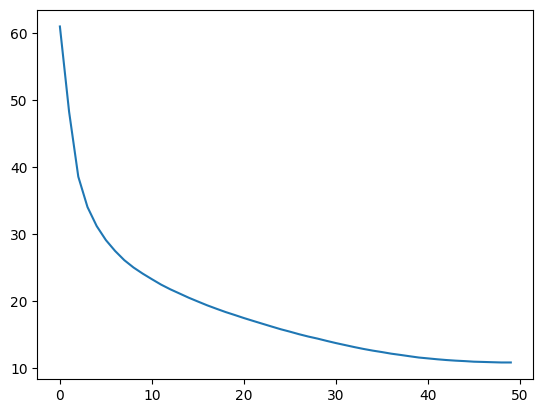

In [27]:
# @title Training loop for the sequence predictor
sequence_predictor.train()
if RESUME_FROM_CHECKPOINT and start_epoch > 0:
    losses = []
else:
    losses = []

max_grad_norm =1.0

for epoch in range(start_epoch, N_EPOCHS):

    running_loss = 0.0
    for frames, descriptions, image_target, text_target  in train_dataloader:
      descriptions = descriptions.to(device)
      frames = frames.to(device)
      image_target = image_target.to(device)
      text_target = text_target.to(device)
      pred_image_content, pred_image_context, predicted_text_logits_k, _, _, kl_loss = sequence_predictor(frames, descriptions, text_target)
      loss_im = criterion_images(pred_image_content, image_target)
      mu_global = frames.mean(dim=[0, 1])
      mu_global = mu_global.unsqueeze(0).expand_as(pred_image_context)
      loss_context = criterion_ctx(pred_image_context, mu_global)
      prediction_flat = predicted_text_logits_k.reshape(-1, tokenizer.vocab_size)
      target_labels = text_target.squeeze(1)[:, 1:]
      target_flat = target_labels.reshape(-1)
      loss_text = criterion_text(prediction_flat, target_flat)
      loss = (LOSS_IMG_W * loss_im +
                LOSS_TEXT_W * loss_text +
                LOSS_CTX_W * loss_context)
      if kl_loss is not None:
        loss = loss + KL_WEIGHT * kl_loss
      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(sequence_predictor.parameters(), max_grad_norm)

      optimizer.step()
      scheduler.step()

      running_loss += loss.item() * frames.size(0)
    if (epoch + 1) % 10 == 0:
        sequence_predictor.eval()
        print("\nValidation on training dataset")
        print("----------------")
        validation(sequence_predictor, train_dataloader, epoch=epoch,
                  tokenizer=tokenizer,
                  device=device,
                  save_dir=str(RESULTS_DIR / 'visualizations'))

        print("\nValidation on validation dataset")
        print("----------------")
        validation(sequence_predictor, val_dataloader, epoch=epoch,
                  tokenizer=tokenizer,
                  device=device,
                  save_dir=str(RESULTS_DIR / 'visualizations'))
        sequence_predictor.train()

    epoch_loss = running_loss / len(train_dataloader.dataset)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Loss: {epoch_loss:.4f}')

    save_frequency = config.get('logging', {}).get('save_every_n_epochs', 1)
    if (epoch + 1) % save_frequency == 0:
      checkpoint_filename = f"{EXPERIMENT_NAME}_epoch_{epoch:03d}.pth"
      checkpoint_path = CHECKPOINT_DIR / checkpoint_filename
      CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

      checkpoint = {
        'epoch': epoch,
        'model_state_dict': sequence_predictor.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': epoch_loss,
        'losses': losses,
        'experiment': EXPERIMENT_NAME,
        'config': config
        }

      torch.save(checkpoint, checkpoint_path)
      print(f"Checkpoint saved: {checkpoint_path}")

plt.plot(losses)
plt.show()


In [28]:
test_metrics = {
    'image_mae': 0.0,
    'image_mse': 0.0,
    'text_perplexity': 0.0,
    'ssim_score': 0.0,
}

sequence_predictor.eval()
total_samples = 0
all_image_mae = []
all_image_mse = []
total_text_loss = 0.0
total_text_tokens = 0

with torch.no_grad():
    for frames, descriptions, image_target, text_target in test_dataloader:
        descriptions = descriptions.to(device)
        frames = frames.to(device)
        image_target = image_target.to(device)
        text_target = text_target.to(device)

        pred_image_content, pred_image_context, predicted_text_logits_k, _, _, kl_loss = sequence_predictor(
            frames, descriptions, text_target
        )
        mae = torch.abs(pred_image_content - image_target).mean().item()
        all_image_mae.append(mae)

        mse = torch.nn.functional.mse_loss(pred_image_content, image_target).item()
        all_image_mse.append(mse)
        prediction_flat = predicted_text_logits_k.reshape(-1, tokenizer.vocab_size)
        target_labels = text_target.squeeze(1)[:, 1:]
        target_flat = target_labels.reshape(-1)

        pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
        valid_mask = target_flat != pad_token_id

        if valid_mask.sum() > 0:
            ce_loss = torch.nn.functional.cross_entropy(
                prediction_flat[valid_mask],
                target_flat[valid_mask],
                reduction='sum'
            ).item()

            num_tokens = valid_mask.sum().item()
            total_text_loss += ce_loss
            total_text_tokens += num_tokens

        total_samples += frames.size(0)

avg_image_mae = np.mean(all_image_mae)
avg_image_mse = np.mean(all_image_mse)

if total_text_tokens > 0:
    avg_text_loss = total_text_loss / total_text_tokens
    avg_text_perplexity = np.exp(avg_text_loss)
else:
    avg_text_perplexity = float('inf')

print(f"\nTest Set Results ({total_samples} samples):")
print(f"  Image MAE: {avg_image_mae:.6f}")
print(f"  Image MSE: {avg_image_mse:.6f}")
print(f"  Text Perplexity: {avg_text_perplexity:.6f}")
print(f"  (Text tokens evaluated: {total_text_tokens})")
test_metrics['image_mae'] = avg_image_mae
test_metrics['image_mse'] = avg_image_mse
test_metrics['text_perplexity'] = avg_text_perplexity
sequence_predictor.train()


Test Set Results (626 samples):
  Image MAE: 0.241421
  Image MSE: 0.078769
  Text Perplexity: 45.266454
  (Text tokens evaluated: 58361)


SequencePredictor(
  (image_encoder): VisualEncoder(
    (conv_layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
    )
    (fc): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=65536, out_fe

In [29]:
import csv
from datetime import datetime

detailed_results = {
    'experiment_name': EXPERIMENT_NAME,
    'timestamp': datetime.now().isoformat(),
    'n_epochs': N_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'use_cross_modal_attention': USE_CROSS_MODAL,
    'use_vae_decoder': USE_VAE,
    'kl_weight': KL_WEIGHT,
    'latent_dim': LATENT_DIM,
    'embedding_dim': EMBEDDING_DIM,
    'gru_hidden_dim': GRU_HIDDEN_DIM,
    'image_weight': LOSS_IMG_W,
    'text_weight': LOSS_TEXT_W,
    'context_weight': LOSS_CTX_W,
    'final_training_loss': losses[-1] if losses else None,
    'image_mae': test_metrics['image_mae'],
    'image_mse': test_metrics['image_mse'],
    'text_perplexity': test_metrics['text_perplexity'],
}

metrics_file = RESULTS_DIR / 'metrics.csv'
file_exists = metrics_file.exists()

with open(metrics_file, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=detailed_results.keys())
    writer.writeheader()
    writer.writerow(detailed_results)

In [40]:
results_data = []

for exp_folder in (PROJECT_ROOT / 'results').iterdir():
    if exp_folder.is_dir():
        metrics_file = exp_folder / 'metrics.csv'
        if metrics_file.exists():
            with open(metrics_file, 'r') as f:
                reader = csv.DictReader(f)
                for row in reader:
                    results_data.append(row)

if results_data:
    print("\nComparison Table:")
    print(f"{'Experiment':<30} {'Image MAE':<15} {'Image MSE': <15} {'Text Perplexity':<15} ")

    for result in results_data:
        exp_name = result['experiment_name']
        img_mae = float(result['image_mae']) if result['image_mae'] else 0
        img_mse = float(result['image_mse']) if result['image_mse'] else 0
        text_perp = float(result['text_perplexity']) if result['text_perplexity'] else 0

        print(f"{exp_name:<30} {img_mae:<15.6f} {img_mse:<15.6f} {text_perp:<15.6f}")

    print("\nImprovement Analysis:")
    baseline = None
    for result in results_data:
        if result['experiment_name'] == 'baseline':
            baseline = result
            break

    if baseline:
        baseline_mae = float(baseline['image_mae'])
        baseline_perp = float(baseline['text_perplexity'])
        baseline_mse = float(baseline['image_mse'])

        print("\nBaseline reference:")
        print(f"  Image MAE: {baseline_mae:.6f}")
        print(f"  Text Perplexity: {baseline_perp:.6f}")

        print("\nImprovement vs Baseline:")
        for result in results_data:
            if result['experiment_name'] != 'baseline':
                exp_name = result['experiment_name']
                img_mae = float(result['image_mae'])
                img_mse = float(result['image_mse'])
                text_perp = float(result['text_perplexity'])

                mae_improvement = ((img_mae - baseline_mae) / baseline_mae) * 100
                mse_improvement = ((img_mse - baseline_mse) / baseline_mse) * 100
                perp_improvement = ((text_perp -baseline_perp) / baseline_perp) * 100

                print(f"\n{exp_name}:")
                print(f"  Image MAE: {mae_improvement:+.2f}%")
                print(f"  Text Perplexity: {perp_improvement:+.2f}%")
                print(f"  Image MSE: {mse_improvement:+.2f}%")


Comparison Table:
Experiment                     Image MAE       Image MSE       Text Perplexity 
cross_modal_plus_vae           0.241443        0.078763        46.242467      
with_cross_modal_attention     0.241406        0.078778        38.490519      
baseline                       0.241272        0.078956        66.529607      
with_vae_decoder               0.241421        0.078769        45.266454      

Improvement Analysis:

Baseline reference:
  Image MAE: 0.241272
  Text Perplexity: 66.529607

Improvement vs Baseline:

cross_modal_plus_vae:
  Image MAE: +0.07%
  Text Perplexity: -30.49%
  Image MSE: -0.24%

with_cross_modal_attention:
  Image MAE: +0.06%
  Text Perplexity: -42.15%
  Image MSE: -0.23%

with_vae_decoder:
  Image MAE: +0.06%
  Text Perplexity: -31.96%
  Image MSE: -0.24%


# **Appendix**

This code computes the average images in case you want to use them. Notice that the average should be all zeros!